<a href="https://colab.research.google.com/github/PederRonning/SOK3022/blob/main/CPI_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
%pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.9 MB/s eta 0:00:00


In [2]:
%pip install pyjstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 38.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyjstat: filename=pyjstat-2.4.0-py3-none-any.whl size=22763 sha256=a1079bd15b899339dbd2b02f5a134da3dfdf18bbe60abe7b1300d70df56d70d9
  Stored in directory: /root/.cache/pip/wheels/d7/b0/ac/350c026feabb6a22b2a5b3fb1f694e724c0f57c2c43ccaf738
Successfully built pyjstat


In [160]:
import pandas as pd
from pyjstat import pyjstat
import requests
import matplotlib.pyplot as plt
import numpy as np

# KPI
POST_URL = 'https://data.ssb.no/api/v0/no/table/08981'

payload = {
  "query": [
    {
      "code": "Maaned",
      "selection": {
        "filter": "item",
        "values": [
          "01",
          "02",
          "03",
          "04",
          "05",
          "06",
          "07",
          "08",
          "09",
          "10",
          "11",
          "12"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

resultat = requests.post(POST_URL, json = payload)
# Resultat gir bare http statuskode - 200 hvis OK. Body ligger i resultat.text
print(resultat)

dataset = pyjstat.Dataset.read(resultat.text)
df = dataset.write('dataframe')
#df = df[['år', 'value']]
#df.set_index('år', inplace=True)

<Response [200]>


In [161]:
#df['år'] = pd.to_datetime(df['år'], format='%Y')
# Map Norwegian month names to month numbers
month_mapping = {
    'Januar': 1,
    'Februar': 2,
    'Mars': 3,
    'April': 4,
    'Mai': 5,
    'Juni': 6,
    'Juli': 7,
    'August': 8,
    'September': 9,
    'Oktober': 10,
    'November': 11,
    'Desember': 12
}
df['måned'] = df['måned'].map(month_mapping)  # Apply mapping

# remove NA
df = df.dropna()

In [162]:
df

,måned,statistikkvariabel,år,value
1,1,Konsumprisindeks (2015=100),1921,5.7
2,1,Konsumprisindeks (2015=100),1922,4.6
3,1,Konsumprisindeks (2015=100),1923,4.0
4,1,Konsumprisindeks (2015=100),1924,4.1
5,1,Konsumprisindeks (2015=100),1925,4.7
...,...,...,...,...
1266,12,Konsumprisindeks (2015=100),2020,112.9
1267,12,Konsumprisindeks (2015=100),2021,118.9
1268,12,Konsumprisindeks (2015=100),2022,125.9
1269,12,Konsumprisindeks (2015=100),2023,131.9


In [163]:
from pandas.tseries.offsets import MonthEnd

# rename år to year
df.rename(columns={'år': 'year'}, inplace=True)
# rename måned til month
df.rename(columns={'måned': 'month'}, inplace=True)

df['time'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1)) + MonthEnd(1)
df = df.sort_values(by=['time'])

In [164]:
df = df[['time', 'value']]

# set date column as index
df.set_index('time', inplace=True)

<Axes: xlabel='time'>

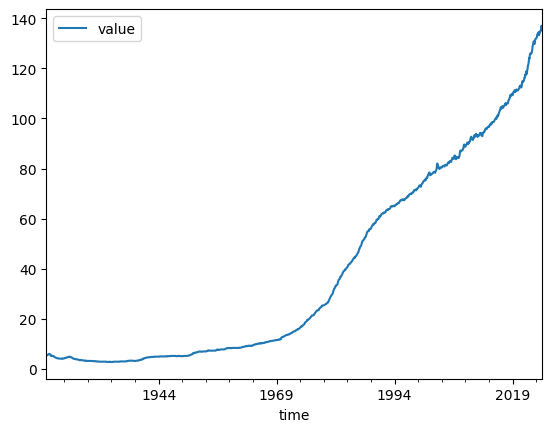

In [165]:
df.plot()

In [166]:
df['value'] = df['value'].pct_change() * 100
df = df.dropna()

In [167]:
df.describe()

,value
count,1261.000000
mean,0.265825
std,0.953099
min,-5.263158
25%,0.000000
50%,0.000000
75%,0.571429
max,8.108108


In [168]:
df_2010 = df[df.index > '2005-01-01']

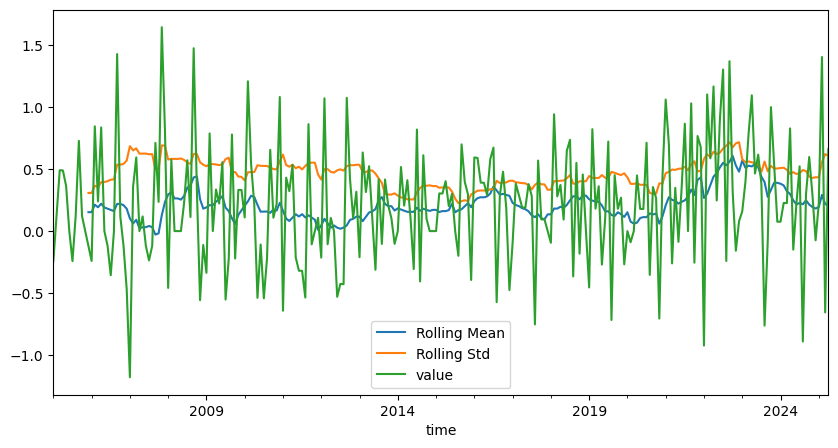

In [169]:
time_series = df_2010['value']
time_series.rolling(window=12).mean().plot(label='Rolling Mean')
time_series.rolling(window=12).std().plot(label='Rolling Std')
time_series.plot(figsize=(10,5))
plt.legend()
plt.show()

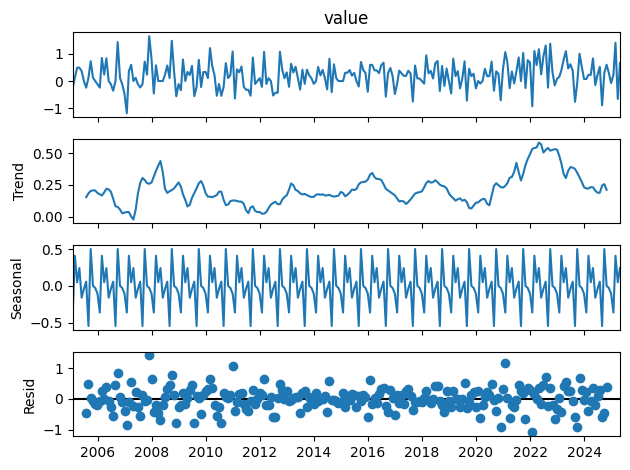

In [170]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(time_series)
fig = decomp.plot()

In [171]:
# check if inflation series is stationary
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(time_series):
    result = adfuller(time_series, autolag='AIC')
    print('1. ADF: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Num of Lags: ', result[2])
    print('4. Num of Observations: ', result[3])
    print('5. Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)

    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

# run function
adf_test(df['value'])

1. ADF:  -6.300063689065199
2. P-value:  3.4295286540646164e-08
3. Num of Lags:  17
4. Num of Observations:  1243
5. Critial Values:
	 1% :  -3.435621806786881
	 5% :  -2.8638680226791444
	 10% :  -2.5680094689100477

Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.


In [175]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(df['value'], test='adf'))
print(ndiffs(df['value'], test='kpss'))
print(ndiffs(df['value'], test='pp'))

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [177]:
%pip install --upgrade numpy
%pip install --upgrade --force-reinstall pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 82.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━